In [14]:
#necessary package import
#Numpy
import numpy as np
from numpy.linalg import multi_dot
from math import factorial, tanh
#Matplotlib
import matplotlib.pyplot as plt
#Scipy
from scipy.linalg import block_diag
#Thewalrus
from thewalrus import perm
#Strawberryfields
import strawberryfields as sf
from strawberryfields.ops import *
#import mplhep as hep
#Qutip
from qutip import *

In [15]:
#Setting Variables
#Rotation gates
"""
R1 = 1
R2 = np.pi/4
R3 = 1
R4 = np.pi/4
"""
R1 = 0.5719
R2 = -1.9782
R3 = 2.0603
R4 = 0.0644
"""
#Beamsplitters
BT1 = np.pi/4;  BP1 = np.pi/2
BT2 = np.pi/4;  BP2 = np.pi/2
BT3 = np.pi/4;  BP3 = np.pi/2
BT4 = np.pi/4;  BP4 = np.pi/2
BT5 = np.pi/4;  BP5 = np.pi/2
BT6 = np.pi/4;  BP6 = np.pi/2
BT7 = np.pi/4;  BP7 = np.pi/2
BT8 = np.pi/4;  BP8 = np.pi/2
"""
BT1 = 0.7804;  BP1 = 0.8578
BT2 = 0.06406; BP2 = 0.5165
BT3 = 0.473;   BP3 = 0.1176
BT4 = 0.563;   BP4 = 0.1517
BT5 = 0.1323;  BP5 = 0.9946
BT6 = 0.311;   BP6 = 0.3231
BT7 = 0.4348;  BP7 = 0.0798
BT8 = 0.4368;  BP8 = 0.6157


In [16]:
#Rotation gate calculation
Uphase = np.diag([np.exp(R1*1j),np.exp(R2*1j),np.exp(R3*1j),np.exp(R4*1j)])

In [26]:
#Beamsplitter calculation
#Put variables
BSargs = [(BT1, BP1),(BT2, BP2),
          (BT3, BP3),
          (BT4, BP4),(BT5, BP5),
          (BT6, BP6),
          (BT7, BP7),(BT8, BP8)]

t_r_amplitudes = [(np.cos(q), np.exp(p*1j)*np.sin(q)) for q,p in BSargs]

BSunitaries = [np.array([[t, -np.conj(r)], [r, t]]) for t,r in t_r_amplitudes]

UBS1 = block_diag(*BSunitaries[0:2])
UBS2 = block_diag([[1]], BSunitaries[2], [[1]])
UBS3 = block_diag(*BSunitaries[3:5])
UBS4 = block_diag([[1]], BSunitaries[5], [[1]])
UBS5 = block_diag(*BSunitaries[6:8])

In [27]:
U = multi_dot([UBS5, UBS4, UBS3, UBS2, UBS1, Uphase])
print(np.round(U,4))

[[ 0.2195-0.2565j  0.6111+0.5242j -0.1027+0.4745j -0.0273+0.0373j]
 [ 0.4513+0.6026j  0.457 +0.0123j  0.1316-0.4504j  0.0353-0.0532j]
 [ 0.0387+0.4927j -0.0192-0.3218j -0.2408+0.5244j -0.4584+0.3296j]
 [-0.1566+0.2246j  0.11  -0.1638j -0.4212+0.1836j  0.8188+0.068j ]]


In [34]:
# Calculating the probability for each state in measure_states
measure_states = [[q1, q2, q3, q4] for q1 in range(5) for q2 in range(5) for q3 in range(5) for q4 in range(5) if q1 + q2 + q3 + q4 == 4]

In [35]:
input = [1, 1, 1, 1]

def unitary_mapping(output):
    # The two lines below are the extracted row and column indices.
    list_rows = sum([[i] * output[i] for i in range(len(output))],[])
    list_columns = sum([[i] * input[i] for i in range(len(input))],[])
    Umap = U[:,list_columns][list_rows,:]
    return Umap

def probs_theory(output):
    perm_squared = np.abs(perm(unitary_mapping(output), method="ryser"))**2
    denominator = np.prod([factorial(inp) for inp in input]) * np.prod([factorial(out) for out in output])
    return perm_squared / denominator

In [36]:
#Fock states generation
#Setting up dimension & number of photons in each mode
Dim = 5

#Input
n1 = 1
n2 = 1
n3 = 1
n4 = 1

#Qubits
#Vaccum state 
vq = fock(Dim, 0)
#Input of the Vaccum state
Invq = tensor(vq, vq ,vq ,vq)

#Creation operators
ad1 = tensor(create(Dim), qeye(Dim), qeye(Dim), qeye(Dim))
ad2 = tensor(qeye(Dim), create(Dim), qeye(Dim), qeye(Dim))
ad3 = tensor(qeye(Dim), qeye(Dim), create(Dim), qeye(Dim))
ad4 = tensor(qeye(Dim), qeye(Dim), qeye(Dim), create(Dim))

In [37]:
#Calculating the detection probability of each state
# Initialize the total probability
total_probability_T = 0  
total_probability_Qutip = 0
prob_Qutip = 0

#Calculating probability
def cal_probability(state):
    Oq1 = 1/np.sqrt(factorial(n1)) * pow(Oad1, n1)
    Oq2 = 1/np.sqrt(factorial(n2)) * pow(Oad2, n2)
    Oq3 = 1/np.sqrt(factorial(n3)) * pow(Oad3, n3)
    Oq4 = 1/np.sqrt(factorial(n4)) * pow(Oad4, n4)
    product = Oq1 * Oq2 * Oq3 * Oq4
    Output_state = product * Invq
    m1, m2, m3, m4 = state
    d1 = fock(Dim, m1)
    d2 = fock(Dim, m2)
    d3 = fock(Dim, m3)
    d4 = fock(Dim, m4)
    #print(detection_state)
    detection = tensor(d1, d2, d3, d4)
    probability = abs((detection.dag() * Output_state).full()[0][0])**2
    return probability

for i, state in enumerate(measure_states):
    #Calculating operator
    Oad1 = sum([U[i, 0] * [ad1, ad2, ad3, ad4][i] for i in range(4)])
    Oad2 = sum([U[i, 1] * [ad1, ad2, ad3, ad4][i] for i in range(4)])
    Oad3 = sum([U[i, 2] * [ad1, ad2, ad3, ad4][i] for i in range(4)]) 
    Oad4 = sum([U[i, 3] * [ad1, ad2, ad3, ad4][i] for i in range(4)])
    #print(state, np.round(ULambda, 4))
    #print(state, Oadag1, Oadag4)
    #each prob
    prob_Qutip = cal_probability(state)
    print(f"Probability of state(Theory)               {state}: {probs_theory(state)*100}%")
    print(f"Probability of state(Simulation_Qutip)     {state}: {prob_Qutip*100}%")
    total_probability_T += probs_theory(state)
    total_probability_Qutip += prob_Qutip

print(f"Total probability(Theory):           {total_probability_T*100}%")
print(f"Total probability(Simulation_Qutip): {total_probability_Qutip*100}%")

Probability of state(Theory)               [0, 0, 0, 4]: 0.9976245740353498%
Probability of state(Simulation_Qutip)     [0, 0, 0, 4]: 0.9976245740353514%
Probability of state(Theory)               [0, 0, 1, 3]: 4.003119536853783%
Probability of state(Simulation_Qutip)     [0, 0, 1, 3]: 4.003119536853776%
Probability of state(Theory)               [0, 0, 2, 2]: 2.716416141240894%
Probability of state(Simulation_Qutip)     [0, 0, 2, 2]: 2.716416141240887%
Probability of state(Theory)               [0, 0, 3, 1]: 0.414559085628145%
Probability of state(Simulation_Qutip)     [0, 0, 3, 1]: 0.41455908562814947%
Probability of state(Theory)               [0, 0, 4, 0]: 6.469120990886585%
Probability of state(Simulation_Qutip)     [0, 0, 4, 0]: 6.469120990886605%
Probability of state(Theory)               [0, 1, 0, 3]: 0.5511529064587104%
Probability of state(Simulation_Qutip)     [0, 1, 0, 3]: 0.5511529064587138%
Probability of state(Theory)               [0, 1, 1, 2]: 0.9347207459242995%
Proba

In [38]:
for i, state in enumerate(measure_states):
    T = probs_theory(state)
    Q = cal_probability(state)
    E = 100*np.abs(T-Q)/T
    Esum =+ E
    print(f"Error of state {state}: {E}%")
print(f"Average of Error: {Esum/len(measure_states)}%")    

Error of state [0, 0, 0, 4]: 1.7388539949050405e-13%
Error of state [0, 0, 1, 3]: 1.5600344821140945e-13%
Error of state [0, 0, 2, 2]: 2.298986675386087e-13%
Error of state [0, 0, 3, 1]: 1.087970615987264e-12%
Error of state [0, 0, 4, 0]: 3.003329657663047e-13%
Error of state [0, 1, 0, 3]: 6.294890059177303e-13%
Error of state [0, 1, 1, 2]: 1.6702861632061902e-13%
Error of state [0, 1, 2, 1]: 1.1629162462173561e-11%
Error of state [0, 1, 3, 0]: 0.0%
Error of state [0, 2, 0, 2]: 2.00527126044675e-13%
Error of state [0, 2, 1, 1]: 0.0%
Error of state [0, 2, 2, 0]: 1.4009282319200543e-13%
Error of state [0, 3, 0, 1]: 1.4967734570821432e-14%
Error of state [0, 3, 1, 0]: 1.3844785943669443e-13%
Error of state [0, 4, 0, 0]: 4.4158031590770907e-13%
Error of state [1, 0, 0, 3]: 0.0%
Error of state [1, 0, 1, 2]: 1.1745945880346207e-13%
Error of state [1, 0, 2, 1]: 2.169238101942407e-12%
Error of state [1, 0, 3, 0]: 2.4632958854694493e-13%
Error of state [1, 1, 0, 2]: 7.897638814628147e-14%
Error

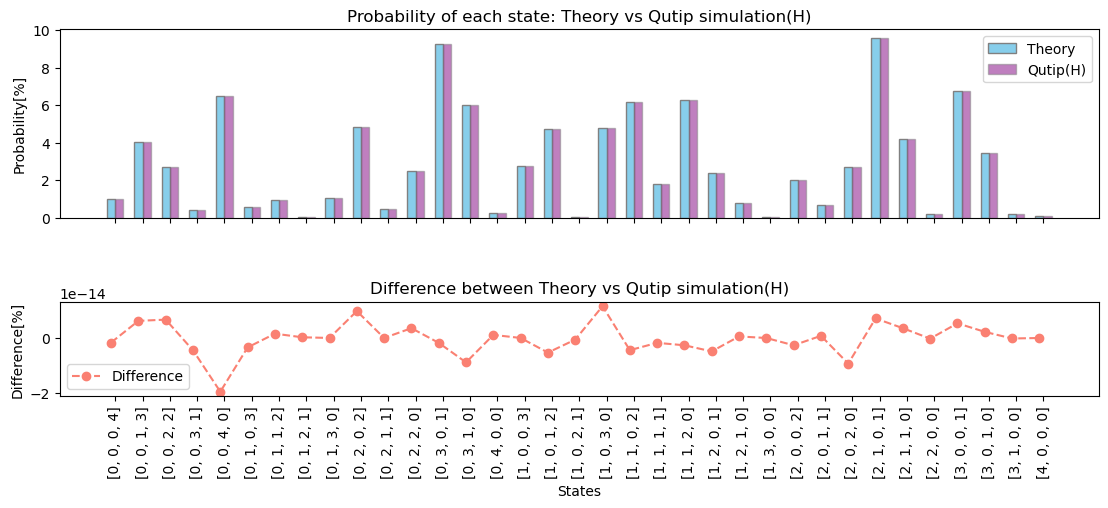

In [39]:
state_probs_theory = [probs_theory(state)*100 for state in measure_states]
state_probs_qutip = [cal_probability(state)*100 for state in measure_states]

# Creating labels for the states
state_labels = [str(state) for state in measure_states]

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(12,6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Define r1, r2, and barWidth
barWidth = 0.3
r1 = np.arange(len(state_probs_theory))
r2 = [x + barWidth for x in r1]

# Creating the bar plot in subplot 1
axs[0].bar(r1, state_probs_theory, color='skyblue', width=barWidth, edgecolor='grey', label='Theory')
axs[0].bar(r2, state_probs_qutip, color='purple', alpha = 0.5, width=barWidth, edgecolor='grey', label='Qutip(H)')

# Adding labels and title to subplot 1
axs[0].set_ylabel("Probability[%]")
axs[0].set_title("Probability of each state: Theory vs Qutip simulation(H)")
axs[0].legend()

# Calculating the difference between theory and simulation
difference = [theory - qutip for theory, qutip in zip(state_probs_theory, state_probs_qutip)]

# Creating the line plot for difference in subplot 2
axs[1].plot(r1, difference, color='salmon', marker='o', label='Difference', linestyle='dashed')

# Adding labels and title to subplot 2
axs[1].set_xlabel("States")
axs[1].set_ylabel("Difference[%]")
axs[1].set_title("Difference between Theory vs Qutip simulation(H)")
axs[1].legend()

# Adding x-axis labels for both subplots
plt.xticks([r + barWidth/2 for r in range(len(state_probs_qutip))], state_labels, rotation=90)

# Adjusting layout to prevent overlap
plt.tight_layout(pad=4.0)

#이미지를 경로에 저장. 확장자는 .pdf, .png, .jpeg등 가능
#plt.savefig('/Users/jaewonlee/Lab Code/PQC/Boson Sampling/Fig/BS_Q_4(Qutip_H).png', transparent = True)

# Showing the plot
plt.show()